In [1]:
import torch
import torch.nn as nn
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GAE,GCNConv,GATConv,SAGEConv

import pandas as pd
import numpy as np

1.导入数据、构图

In [2]:
nodes_data = pd.read_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\net\\nodes_list.csv',header=None)
nodes_data

,0
0,lda
1,hierarchical agglomerative clustering
2,discipline topic
3,data visualization
4,datadriven
...,...
4728,electronic waste
4729,environmentalism
4730,rat
4731,urban space


In [3]:
edges_data = pd.read_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\net\\weighted_links.csv',header=None)
edges_data

,0,1,2
0,discipline topic,hierarchical agglomerative clustering,1
1,discipline topic,lda,1
2,hierarchical agglomerative clustering,lda,1
3,citation pattern,data visualization,1
4,citation pattern,datadriven,1
...,...,...,...
17278,archive,electronic text,1
17279,archive,online delivery,1
17280,electronic text,metadata,1
17281,electronic text,online delivery,1


In [4]:
project_dict = dict(zip(nodes_data[0],nodes_data.index))
project_dict

{'lda': 0,
 'hierarchical agglomerative clustering': 1,
 'discipline topic': 2,
 'data visualization': 3,
 'datadriven': 4,
 'citation pattern': 5,
 'hathi trust digital library': 6,
 'potential tool development': 7,
 'compute education': 8,
 'liberal art compute': 9,
 'liberal education': 10,
 'coproduction': 11,
 'climate change': 12,
 'social science and humanity': 13,
 'conceptual lens': 14,
 'pest control technique': 15,
 'agricultural improvement': 16,
 'entomological investigation': 17,
 'palaeography': 18,
 'multidisciplinary collaboration': 19,
 'computational mean': 20,
 'humanity research': 21,
 'bibliometric evaluation': 22,
 'book review': 23,
 'journal quality indicator': 24,
 'lap': 25,
 'library': 26,
 'collaboration': 27,
 'sustainability': 28,
 'document': 29,
 'use case': 30,
 'activity theory': 31,
 'compute community': 32,
 'social science': 33,
 'citation analysis': 34,
 'isi': 35,
 'internet outage': 36,
 'disaster': 37,
 'dependent': 38,
 'interactive whiteboard

In [5]:
edges_data_num=pd.DataFrame(np.zeros(edges_data.shape))
for i in range(edges_data.shape[0]):
    edges_data_num[0][i]=project_dict[edges_data[0][i]]
    edges_data_num[1][i]=project_dict[edges_data[1][i]]
    edges_data_num[2][i]=edges_data[2][i]
edges_data_num

,0,1,2
0,2.0,1.0,1.0
1,2.0,0.0,1.0
2,1.0,0.0,1.0
3,5.0,3.0,1.0
4,5.0,4.0,1.0
...,...,...,...
17278,248.0,1070.0,1.0
17279,248.0,4732.0,1.0
17280,1070.0,183.0,1.0
17281,1070.0,4732.0,1.0


In [6]:
edges_data_num__reverse=pd.DataFrame(np.zeros(edges_data.shape))
for i in range(edges_data_num__reverse.shape[0]):
    edges_data_num__reverse[0][i]=edges_data_num[1][i]
    edges_data_num__reverse[1][i]=edges_data_num[0][i]
    edges_data_num__reverse[2][i]=edges_data_num[2][i]
edges_data_num__reverse

,0,1,2
0,1.0,2.0,1.0
1,0.0,2.0,1.0
2,0.0,1.0,1.0
3,3.0,5.0,1.0
4,4.0,5.0,1.0
...,...,...,...
17278,1070.0,248.0,1.0
17279,4732.0,248.0,1.0
17280,183.0,1070.0,1.0
17281,4732.0,1070.0,1.0


In [7]:
edges_data_biderect=pd.concat([edges_data_num,edges_data_num__reverse],axis=0)
edges_data_biderect

,0,1,2
0,2.0,1.0,1.0
1,2.0,0.0,1.0
2,1.0,0.0,1.0
3,5.0,3.0,1.0
4,5.0,4.0,1.0
...,...,...,...
17278,1070.0,248.0,1.0
17279,4732.0,248.0,1.0
17280,183.0,1070.0,1.0
17281,4732.0,1070.0,1.0


In [8]:
edge_pyg=[np.array(edges_data_biderect[0]).astype(dtype=int).tolist(),np.array(edges_data_biderect[1]).astype(dtype=int).tolist()]
edge_index = torch.LongTensor(edge_pyg)

In [9]:
#embed=pd.read_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\bert_embedding_whitening128.csv',header=None)
#embed=np.eye(nodes_data.shape[0])
#embed=np.ones([nodes_data.shape[0],128])
embed1=pd.read_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\embedding2.csv',header=None)
embed2=pd.read_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\bert_embedding_whitening128.csv',header=None)
embed3=pd.read_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\embedding1.csv',header=None)
#embed=pd.concat([embed2,embed1],axis=1)
embed=pd.concat([embed1,embed2,embed3],axis=1)
#embed=pd.read_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\embedding2.csv',header=None)
embed

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.008700,0.081825,-0.523698,0.597906,0.122714,-0.456218,0.034991,0.114024,-0.086931,0.642463
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.413814,-0.025329,0.142052,-0.637284,0.176882,0.215634,-0.151164,0.226083,0.392156,0.268685,...,-0.300186,-0.116646,-1.282686,-0.217487,0.804696,-0.097120,-0.126476,0.157971,-0.266505,-0.364618
4,-0.101645,-0.148383,0.098534,-0.528029,0.473487,0.039792,-0.012690,0.492727,-0.129925,0.473836,...,-0.308094,-0.107835,-0.641750,0.090987,0.248216,-0.264086,0.253395,0.222335,-0.125950,0.117572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4729,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4730,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4731,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
from scipy.sparse import diags
def preprocess_features(features):
    rowsum=np.array(features.sum(1))
    r_inv=np.power(rowsum,-1).flatten()
    r_inv[np.isinf(r_inv)]=0.
    r_mat_inv=diags(r_inv)
    features=r_mat_inv.dot(features)
    return torch.tensor(features)

In [11]:
features=torch.tensor(np.array(embed),dtype=torch.float)
x=preprocess_features(features)
edge_weight = torch.tensor(np.array(edges_data_biderect[2]).astype(dtype=float),dtype=torch.float)
edge_attr=edge_weight

创建Data对象

In [12]:
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
data

Data(x=[4733, 384], edge_index=[2, 34566], edge_attr=[34566])

In [13]:
result=pd.DataFrame(np.zeros([11,2]))
result

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


2.训练模型

In [16]:
for time in range(2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = T.Compose([
        T.ToDevice(device),
        T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                          split_labels=True, add_negative_train_samples=True),
    ])

    train_dataset, val_dataset, test_dataset = transform(data)
    #print("Train Data:\n", train_dataset)
    #print("\nValidation Data:\n", val_dataset)
    #print("\nTest Data:\n", test_dataset)
    HIDDEN_SIZE = 32
    OUT_CHANNELS = 16
    EPOCHS = 200
    NUM_FEATURES=data.x.shape[1]
    class GCNEncoder(nn.Module):
        def __init__(self, in_channels, hidden_size, out_channels, dropout):
            super(GCNEncoder, self).__init__()
            self.conv1 = GCNConv(in_channels, hidden_size, cached=True)
            self.conv2 = GCNConv(hidden_size, out_channels, cached=True) 
            self.dropout = nn.Dropout(dropout)

        def forward(self, x, edge_index):
            x_temp1 = self.conv1(x, edge_index).relu()
            x_temp2 = self.dropout(x_temp1)
            return self.conv2(x_temp2, edge_index)
    class GATEncoder(nn.Module):
        def __init__(self, in_channels, hidden_size, out_channels, dropout):
            self.dropout=dropout
            super(GATEncoder, self).__init__()
            self.conv1 = GATConv(in_channels, hidden_size, heads=8, dropout=dropout)
            self.conv2 = GATConv(hidden_size * 8, OUT_CHANNELS, heads=1,dropout=dropout)

        def forward(self,x, edge_index):
            x = F.dropout(x, p=self.dropout)
            x = F.elu(self.conv1(x,edge_index))
            x = F.dropout(x, p=self.dropout)
            x = self.conv2(x, edge_index)
            return x

    class SAGEEncoder(nn.Module):
        def __init__(self, in_channels, hidden_channels, out_channels, dropout):
            super(SAGEEncoder, self).__init__()
            self.convs = nn.ModuleList()
            self.convs.append(SAGEConv(in_channels, hidden_channels))
            self.convs.append(SAGEConv(hidden_channels, out_channels))
            self.dropout = dropout

        #def reset_parameters():
            #for conv in self.convs:
                #conv.reset_parameters()

        def forward(self, x, edge_index):
            x = self.convs[0](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[1](x, edge_index)

            return x


    gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0))
    gae_model = gae_model.to(device)
    #print(gae_model)
    def gae_train(train_data, gae_model, optimizer):
        gae_model.train()
        optimizer.zero_grad()
        z = gae_model.encode(train_data.x, train_data.edge_index)
        loss = gae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
        loss.backward(retain_graph=True)
        optimizer.step()
        return float(loss)

    @torch.no_grad()
    def gae_test(test_data, gae_model):
        gae_model.eval()
        z = gae_model.encode(test_data.x, test_data.edge_index)
        return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    losses = []
    test_aucs = []
    test_aps = []
    train_aucs = []
    train_aps = []
    val_aucs=[]
    val_aps=[]

    optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01)

    best_val_auc = final_test_auc = final_test_ap =best_epoch= 0
    for epoch in range(1, EPOCHS + 1):
        loss = gae_train(train_dataset, gae_model, optimizer)
        losses.append(loss)
        auc, ap = gae_test(test_dataset, gae_model)
        test_aucs.append(auc)
        test_aps.append(ap)

        train_auc, train_ap = gae_test(train_dataset, gae_model)
        train_aucs.append(train_auc)
        train_aps.append(train_ap)

        val_auc, val_ap = gae_test(val_dataset, gae_model)
        val_aucs.append(val_auc)
        val_aps.append(val_ap)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            final_test_auc = auc
            final_test_ap=ap
            best_epoch=epoch
        print('Epoch: {:03d},train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f},val AUC: {:.4f}, val AP: {:.4f},test AUC: {:.4f}, test AP: {:.4f}'.format(epoch, train_auc, train_ap, loss,val_auc, val_ap, auc, ap))
        torch.save(gae_model, str(epoch)+'.pt')
    n=best_epoch
    print(f'Final Test epoch:{best_epoch:.4f},Final Test AUC: {final_test_auc:.4f},Final Test AP:{final_test_ap:.4f}')
    result[0][time]=final_test_auc
    result[1][time]=final_test_ap 
    

Epoch: 001,train AUC: 0.7939, train AP: 0.7790, loss:1.4414,val AUC: 0.7226, val AP: 0.7191,test AUC: 0.7192, test AP: 0.7034
Epoch: 002,train AUC: 0.7933, train AP: 0.7841, loss:1.3439,val AUC: 0.7373, val AP: 0.7372,test AUC: 0.7276, test AP: 0.7164
Epoch: 003,train AUC: 0.7851, train AP: 0.7787, loss:1.2980,val AUC: 0.7281, val AP: 0.7298,test AUC: 0.7160, test AP: 0.7133
Epoch: 004,train AUC: 0.8008, train AP: 0.7921, loss:1.3091,val AUC: 0.7468, val AP: 0.7500,test AUC: 0.7330, test AP: 0.7276
Epoch: 005,train AUC: 0.8190, train AP: 0.8095, loss:1.2989,val AUC: 0.7566, val AP: 0.7607,test AUC: 0.7508, test AP: 0.7436
Epoch: 006,train AUC: 0.8326, train AP: 0.8220, loss:1.2937,val AUC: 0.7673, val AP: 0.7698,test AUC: 0.7633, test AP: 0.7553
Epoch: 007,train AUC: 0.8404, train AP: 0.8298, loss:1.2877,val AUC: 0.7726, val AP: 0.7766,test AUC: 0.7680, test AP: 0.7588
Epoch: 008,train AUC: 0.8420, train AP: 0.8332, loss:1.2631,val AUC: 0.7690, val AP: 0.7758,test AUC: 0.7644, test AP:

Epoch: 067,train AUC: 0.9295, train AP: 0.9172, loss:1.1057,val AUC: 0.8597, val AP: 0.8598,test AUC: 0.8692, test AP: 0.8580
Epoch: 068,train AUC: 0.9297, train AP: 0.9181, loss:1.0818,val AUC: 0.8559, val AP: 0.8551,test AUC: 0.8671, test AP: 0.8559
Epoch: 069,train AUC: 0.9310, train AP: 0.9205, loss:1.0768,val AUC: 0.8558, val AP: 0.8553,test AUC: 0.8694, test AP: 0.8586
Epoch: 070,train AUC: 0.9328, train AP: 0.9226, loss:1.0880,val AUC: 0.8599, val AP: 0.8586,test AUC: 0.8738, test AP: 0.8627
Epoch: 071,train AUC: 0.9337, train AP: 0.9225, loss:1.0863,val AUC: 0.8630, val AP: 0.8627,test AUC: 0.8761, test AP: 0.8648
Epoch: 072,train AUC: 0.9338, train AP: 0.9224, loss:1.1005,val AUC: 0.8632, val AP: 0.8637,test AUC: 0.8781, test AP: 0.8671
Epoch: 073,train AUC: 0.9335, train AP: 0.9216, loss:1.0860,val AUC: 0.8597, val AP: 0.8615,test AUC: 0.8781, test AP: 0.8672
Epoch: 074,train AUC: 0.9329, train AP: 0.9210, loss:1.0802,val AUC: 0.8550, val AP: 0.8576,test AUC: 0.8767, test AP:

Epoch: 133,train AUC: 0.9497, train AP: 0.9424, loss:0.9980,val AUC: 0.8930, val AP: 0.8995,test AUC: 0.9009, test AP: 0.9033
Epoch: 134,train AUC: 0.9494, train AP: 0.9421, loss:0.9937,val AUC: 0.8920, val AP: 0.8984,test AUC: 0.9006, test AP: 0.9031
Epoch: 135,train AUC: 0.9485, train AP: 0.9409, loss:0.9881,val AUC: 0.8881, val AP: 0.8943,test AUC: 0.8980, test AP: 0.9005
Epoch: 136,train AUC: 0.9481, train AP: 0.9400, loss:1.0112,val AUC: 0.8866, val AP: 0.8932,test AUC: 0.8964, test AP: 0.8984
Epoch: 137,train AUC: 0.9494, train AP: 0.9414, loss:0.9791,val AUC: 0.8882, val AP: 0.8940,test AUC: 0.8991, test AP: 0.9005
Epoch: 138,train AUC: 0.9504, train AP: 0.9427, loss:1.0085,val AUC: 0.8905, val AP: 0.8955,test AUC: 0.9020, test AP: 0.9034
Epoch: 139,train AUC: 0.9514, train AP: 0.9438, loss:0.9890,val AUC: 0.8924, val AP: 0.8975,test AUC: 0.9038, test AP: 0.9054
Epoch: 140,train AUC: 0.9527, train AP: 0.9446, loss:1.0090,val AUC: 0.8944, val AP: 0.9001,test AUC: 0.9065, test AP:

Epoch: 199,train AUC: 0.9609, train AP: 0.9539, loss:0.9578,val AUC: 0.9016, val AP: 0.9040,test AUC: 0.9148, test AP: 0.9153
Epoch: 200,train AUC: 0.9604, train AP: 0.9534, loss:0.9419,val AUC: 0.9000, val AP: 0.9026,test AUC: 0.9138, test AP: 0.9141
Final Test epoch:195.0000,Final Test AUC: 0.9158,Final Test AP:0.9146
Epoch: 001,train AUC: 0.7910, train AP: 0.7708, loss:1.5475,val AUC: 0.7349, val AP: 0.7406,test AUC: 0.7450, test AP: 0.7324
Epoch: 002,train AUC: 0.7932, train AP: 0.7744, loss:1.3370,val AUC: 0.7581, val AP: 0.7546,test AUC: 0.7544, test AP: 0.7407
Epoch: 003,train AUC: 0.7816, train AP: 0.7694, loss:1.3454,val AUC: 0.7352, val AP: 0.7351,test AUC: 0.7458, test AP: 0.7389
Epoch: 004,train AUC: 0.7865, train AP: 0.7749, loss:1.3081,val AUC: 0.7384, val AP: 0.7418,test AUC: 0.7491, test AP: 0.7413
Epoch: 005,train AUC: 0.7941, train AP: 0.7827, loss:1.2933,val AUC: 0.7476, val AP: 0.7504,test AUC: 0.7534, test AP: 0.7480
Epoch: 006,train AUC: 0.7981, train AP: 0.7879, 

Epoch: 065,train AUC: 0.9188, train AP: 0.9043, loss:1.0812,val AUC: 0.8666, val AP: 0.8734,test AUC: 0.8640, test AP: 0.8613
Epoch: 066,train AUC: 0.9212, train AP: 0.9070, loss:1.1038,val AUC: 0.8704, val AP: 0.8744,test AUC: 0.8700, test AP: 0.8664
Epoch: 067,train AUC: 0.9215, train AP: 0.9076, loss:1.0891,val AUC: 0.8705, val AP: 0.8724,test AUC: 0.8695, test AP: 0.8656
Epoch: 068,train AUC: 0.9225, train AP: 0.9083, loss:1.0752,val AUC: 0.8676, val AP: 0.8681,test AUC: 0.8677, test AP: 0.8647
Epoch: 069,train AUC: 0.9217, train AP: 0.9077, loss:1.0555,val AUC: 0.8636, val AP: 0.8648,test AUC: 0.8637, test AP: 0.8619
Epoch: 070,train AUC: 0.9224, train AP: 0.9095, loss:1.0854,val AUC: 0.8642, val AP: 0.8674,test AUC: 0.8647, test AP: 0.8627
Epoch: 071,train AUC: 0.9241, train AP: 0.9123, loss:1.1010,val AUC: 0.8699, val AP: 0.8722,test AUC: 0.8705, test AP: 0.8670
Epoch: 072,train AUC: 0.9252, train AP: 0.9121, loss:1.0673,val AUC: 0.8707, val AP: 0.8721,test AUC: 0.8708, test AP:

Epoch: 131,train AUC: 0.9460, train AP: 0.9353, loss:1.0260,val AUC: 0.8993, val AP: 0.9085,test AUC: 0.8902, test AP: 0.8891
Epoch: 132,train AUC: 0.9444, train AP: 0.9329, loss:1.0291,val AUC: 0.8956, val AP: 0.9026,test AUC: 0.8874, test AP: 0.8838
Epoch: 133,train AUC: 0.9429, train AP: 0.9316, loss:1.0101,val AUC: 0.8910, val AP: 0.8989,test AUC: 0.8851, test AP: 0.8825
Epoch: 134,train AUC: 0.9455, train AP: 0.9357, loss:1.0031,val AUC: 0.8940, val AP: 0.9051,test AUC: 0.8887, test AP: 0.8871
Epoch: 135,train AUC: 0.9458, train AP: 0.9363, loss:0.9961,val AUC: 0.8965, val AP: 0.9071,test AUC: 0.8902, test AP: 0.8887
Epoch: 136,train AUC: 0.9463, train AP: 0.9363, loss:1.0053,val AUC: 0.8970, val AP: 0.9088,test AUC: 0.8910, test AP: 0.8884
Epoch: 137,train AUC: 0.9431, train AP: 0.9320, loss:0.9933,val AUC: 0.8925, val AP: 0.9054,test AUC: 0.8862, test AP: 0.8831
Epoch: 138,train AUC: 0.9470, train AP: 0.9368, loss:1.0031,val AUC: 0.8982, val AP: 0.9112,test AUC: 0.8938, test AP:

Epoch: 197,train AUC: 0.9554, train AP: 0.9454, loss:0.9786,val AUC: 0.9083, val AP: 0.9150,test AUC: 0.9117, test AP: 0.9134
Epoch: 198,train AUC: 0.9551, train AP: 0.9449, loss:0.9821,val AUC: 0.9072, val AP: 0.9129,test AUC: 0.9103, test AP: 0.9090
Epoch: 199,train AUC: 0.9557, train AP: 0.9454, loss:0.9826,val AUC: 0.9099, val AP: 0.9147,test AUC: 0.9109, test AP: 0.9076
Epoch: 200,train AUC: 0.9559, train AP: 0.9461, loss:0.9899,val AUC: 0.9118, val AP: 0.9166,test AUC: 0.9107, test AP: 0.9075
Final Test epoch:184.0000,Final Test AUC: 0.9118,Final Test AP:0.9143


3.预测新边

In [15]:
result[0][10]=np.mean(result[0][0:10])
result[1][10]=np .mean(result[1][0:10])
result

,0,1
0,0.909166,0.909761
1,0.915036,0.911061
2,0.920493,0.926689
3,0.907557,0.906336
4,0.920460,0.925289
5,0.918607,0.919550
6,0.912038,0.913142
7,0.895222,0.888136
8,0.909401,0.907970
9,0.912544,0.914900


In [18]:
result.to_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\result\\gcn_author1+author2.csv',header=0,index=0)

In [19]:
model=torch.load(str(n)+".pt")

In [20]:
z = model.encode(data.x, data.edge_index)
z

tensor([[-0.0651, -0.3429,  0.3576,  ...,  0.1915, -0.1944,  0.0095],
        [-0.1777,  0.0036,  0.1425,  ...,  0.1741, -0.1475, -0.1192],
        [-0.1777,  0.0036,  0.1425,  ...,  0.1741, -0.1475, -0.1192],
        ...,
        [-0.1075,  0.0010, -0.6805,  ...,  0.6060,  0.1654, -0.3141],
        [ 0.0282,  0.0865, -0.7341,  ...,  0.5466,  0.1595, -0.2990],
        [ 0.3454,  0.0681, -0.2448,  ..., -0.1909, -0.2925, -0.2660]],
       grad_fn=<AddBackward0>)

In [44]:
#z=z.detach().numpy()
#norm1 = np.linalg.norm(z,axis=-1,keepdims=True)
#norm1

In [45]:
#z=z/norm1
#z=torch.Tensor(z)
#z

In [46]:
#def decode_all(z):
#        prob_adj = z @ z.t()
#        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [21]:
def decode_all(z):
        adj = torch.matmul(z, z.t())
        return (torch.sigmoid(adj)>0.5).nonzero(as_tuple=False).t()

In [22]:
final_edge_index = decode_all(z)
final_edge_index.shape

torch.Size([2, 11411469])

In [23]:
prob_adj = torch.sigmoid(z @ z.t())
prob_adj.shape

torch.Size([4733, 4733])

In [24]:
newedge=pd.DataFrame(final_edge_index.numpy()).T

In [25]:
l=[]
for i in range(newedge.shape[0]):
    l.append(float(prob_adj[newedge[0][i]][newedge[1][i]]))
l

[0.7203723788261414,
 0.6251851916313171,
 0.6251851916313171,
 0.955325722694397,
 0.567082941532135,
 0.567082941532135,
 0.5365203022956848,
 0.5365203022956848,
 0.5706377029418945,
 0.6238405704498291,
 0.6426406502723694,
 0.6426406502723694,
 0.5054429769515991,
 0.7823199033737183,
 0.8509165644645691,
 0.5327759981155396,
 0.661300539970398,
 0.5881945490837097,
 0.6226270198822021,
 0.5881945490837097,
 0.6949578523635864,
 0.5259444713592529,
 0.52734375,
 0.52734375,
 0.52734375,
 0.5842308402061462,
 0.7368674874305725,
 0.5214240550994873,
 0.5214240550994873,
 0.7255455851554871,
 0.5497919321060181,
 0.6305491924285889,
 0.5439050793647766,
 0.5439050793647766,
 0.7010329961776733,
 0.5734859108924866,
 0.5573611855506897,
 0.6041002869606018,
 0.6641361713409424,
 0.6064664721488953,
 0.5860247015953064,
 0.6074795722961426,
 0.5300701856613159,
 0.6595712900161743,
 0.5300701856613159,
 0.5492746233940125,
 0.5068264007568359,
 0.5218754410743713,
 0.8016687631607056,

In [26]:
newedge['dot']=l
newedge=newedge.sort_values(by='dot',ascending=False)
newedge.columns=['source','target','dot']
newedge

,source,target,dot
1080701,441,2720,1.0
6269004,2585,3514,1.0
8512566,3515,3497,1.0
8512565,3515,3496,1.0
8512564,3515,3494,1.0
...,...,...,...
5932826,2446,112,0.5
5932827,2446,113,0.5
277668,113,2446,0.5
273052,111,2446,0.5


探索

In [53]:
oldedge=edges_data_biderect
oldedge.reset_index(drop=True, inplace=True)
oldedge.columns=['source','target','dot']

In [54]:
for i in range(oldedge.shape[0]):
    oldedge['dot'][i]=float(prob_adj[int(oldedge['source'][i])][int(oldedge['target'][i])])
oldedge=oldedge.sort_values(by='dot',ascending=False)
oldedge

,source,target,dot
12638,3746.0,3748.0,1.000000
11123,2031.0,3400.0,1.000000
2497,233.0,454.0,1.000000
2496,233.0,442.0,1.000000
28948,1130.0,3536.0,1.000000
...,...,...,...
6548,2262.0,2263.0,0.002695
29997,1381.0,3764.0,0.000086
12714,3764.0,1381.0,0.000086
17571,167.0,196.0,0.000010


In [55]:
oldedge.to_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\result\\oldedge_sort1.csv',sep=',',index=0)
newedge.to_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\result\\newedge_sort1.csv',sep=',',index=0)

In [56]:
otheredge=pd.concat([newedge,oldedge,oldedge])
otheredge=otheredge.drop_duplicates(subset=['source','target'],keep=False)
otheredge=otheredge.sort_values(by='dot',ascending=False)
otheredge

,source,target,dot
8881201,3562.0,1822.0,1.0
8780856,3517.0,2385.0,1.0
8780790,3517.0,1876.0,1.0
3908858,1558.0,4405.0,1.0
3908859,1558.0,4406.0,1.0
...,...,...,...
1897095,748.0,1103.0,0.5
2756971,1103.0,747.0,0.5
7648569,3053.0,2842.0,0.5
7131793,2842.0,3053.0,0.5


In [57]:
otheredge[otheredge['dot']==1]

,source,target,dot
8881201,3562.0,1822.0,1.0
8780856,3517.0,2385.0,1.0
8780790,3517.0,1876.0,1.0
3908858,1558.0,4405.0,1.0
3908859,1558.0,4406.0,1.0
...,...,...,...
10945344,4405.0,2705.0,1.0
10945345,4405.0,2716.0,1.0
10945346,4405.0,2720.0,1.0
10945349,4405.0,2728.0,1.0


In [58]:
otheredge.to_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\result\\otheredge_sort1.csv',sep=',',index=0)

In [59]:
otheredge1 = otheredge.drop(otheredge[otheredge['source']==otheredge['target']].index)
otheredge1.reset_index(drop=True, inplace=True)
otheredge1.to_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\result\\otheredge_sort_noselfcircle1.csv',sep=',',index=0)

In [60]:
otheredge2=otheredge1[0:2000]
otheredge2

,source,target,dot
0,3562.0,1822.0,1.0
1,3517.0,2385.0,1.0
2,3517.0,1876.0,1.0
3,1558.0,4405.0,1.0
4,1558.0,4406.0,1.0
...,...,...,...
1995,4191.0,4405.0,1.0
1996,3535.0,2671.0,1.0
1997,1477.0,2721.0,1.0
1998,548.0,2721.0,1.0


In [61]:
for i in range(otheredge2.shape[0]):
    if otheredge2['source'][i]<otheredge2['target'][i]:
        otheredge2['source'][i]=otheredge2['source'][i]
        otheredge2['target'][i]=otheredge2['target'][i]
    else:
        mid=otheredge2['source'][i]
        otheredge2['source'][i]=otheredge2['target'][i]
        otheredge2['target'][i]=mid
otheredge2

C:\Users\lenovo\AppData\Local\Temp\ipykernel_77044\1426314943.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otheredge2['source'][i]=otheredge2['target'][i]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_77044\1426314943.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otheredge2['target'][i]=mid
C:\Users\lenovo\AppData\Local\Temp\ipykernel_77044\1426314943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otheredge2['source'][

,source,target,dot
0,1822.0,3562.0,1.0
1,2385.0,3517.0,1.0
2,1876.0,3517.0,1.0
3,1558.0,4405.0,1.0
4,1558.0,4406.0,1.0
...,...,...,...
1995,4191.0,4405.0,1.0
1996,2671.0,3535.0,1.0
1997,1477.0,2721.0,1.0
1998,548.0,2721.0,1.0


In [62]:
otheredge2=otheredge2.drop_duplicates(keep="first")
otheredge2.reset_index(drop=True,inplace=True)
otheredge2

,source,target,dot
0,1822.0,3562.0,1.0
1,2385.0,3517.0,1.0
2,1876.0,3517.0,1.0
3,1558.0,4405.0,1.0
4,1558.0,4406.0,1.0
...,...,...,...
1926,4191.0,4405.0,1.0
1927,2671.0,3535.0,1.0
1928,1477.0,2721.0,1.0
1929,548.0,2721.0,1.0


In [63]:
project_dict = dict(zip(nodes_data.index,nodes_data[0]))
project_dict

{0: 'lda',
 1: 'hierarchical agglomerative clustering',
 2: 'discipline topic',
 3: 'data visualization',
 4: 'datadriven',
 5: 'citation pattern',
 6: 'hathi trust digital library',
 7: 'potential tool development',
 8: 'compute education',
 9: 'liberal art compute',
 10: 'liberal education',
 11: 'coproduction',
 12: 'climate change',
 13: 'social science and humanity',
 14: 'conceptual lens',
 15: 'pest control technique',
 16: 'agricultural improvement',
 17: 'entomological investigation',
 18: 'palaeography',
 19: 'multidisciplinary collaboration',
 20: 'computational mean',
 21: 'humanity research',
 22: 'bibliometric evaluation',
 23: 'book review',
 24: 'journal quality indicator',
 25: 'lap',
 26: 'library',
 27: 'collaboration',
 28: 'sustainability',
 29: 'document',
 30: 'use case',
 31: 'activity theory',
 32: 'compute community',
 33: 'social science',
 34: 'citation analysis',
 35: 'isi',
 36: 'internet outage',
 37: 'disaster',
 38: 'dependent',
 39: 'interactive whiteb

In [64]:
for i in range (otheredge2.shape[0]):
    otheredge2['source'][i]=project_dict[int(otheredge2['source'][i])]
    otheredge2['target'][i]=project_dict[int(otheredge2['target'][i])]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_77044\168160840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otheredge2['source'][i]=project_dict[int(otheredge2['source'][i])]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_77044\168160840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otheredge2['target'][i]=project_dict[int(otheredge2['target'][i])]


In [65]:
otheredge2

,source,target,dot
0,semantic enrichment,georeferencing,1.0
1,telemedicine,scientific paper visualization,1.0
2,shape grammar,scientific paper visualization,1.0
3,eastern europe,collection access,1.0
4,eastern europe,heritage collection,1.0
...,...,...,...
1926,british museum,collection access,1.0
1927,digital sociology,textmining,1.0
1928,autoencoders,wikidata politics,1.0
1929,interpretive method,wikidata politics,1.0


In [66]:
otheredge2.to_csv('E:\\GraphSAGE\\Scopus_2022_9_21_1\\result\\topic_otheredge_sort_noselfcircle3_4.csv',sep=',',index=0)

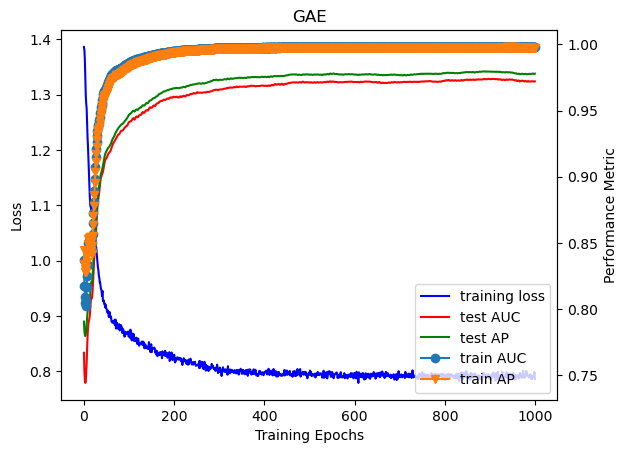

In [57]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap):
    """
    绘制训练过程中损失和性能指标的变化
    
    Args
    ---- 
    losses, test_auc, test_ap, train_auc, train_ap: 训练过程的输出列表
    """
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    ax.set_xlabel("Training Epochs")
    ax2.set_ylabel("Performance Metric")
    ax.set_ylabel("Loss")

    plt.title(title)
    p1, = ax.plot(losses, "b-", label="training loss")
    p2, = ax2.plot(test_auc, "r-", label="test AUC")
    p3, = ax2.plot(test_ap, "g-", label="test AP")
    p4, = ax2.plot(train_auc, "o-", label="train AUC")
    p5, = ax2.plot(train_ap, "v-", label="train AP")
    plt.legend(handles=[p1, p2, p3, p4, p5])
    plt.show()

plot_training_stats('GAE', losses, test_auc, test_ap, train_aucs, train_aps)